# Envoyer 28 emmanvel.de.bezenac@lip6.fr
## Objet : nom prenom 3I005 Projet1

In [9]:

import email
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

def read_file(fname):
    """ Lit un fichier compose d'une liste de emails, chacun separe par au moins 2 lignes vides."""
    f = open(fname,'rb')
    raw_file = f.read()
    f.close()
    raw_file = raw_file.replace(b'\r\n',b'\n')
    emails =raw_file.split(b"\n\n\nFrom")
    emails = [emails[0]]+ [b"From"+x for x in emails[1:] ]
    return emails

def get_body(em):
    """ Recupere le corps principal de l'email """
    body = em.get_payload()
    if type(body) == list:
        body = body[0].get_payload()
    try:
        res = str(body)
    except Exception:
        res=""
    return res

def clean_body(s):
    """ Enleve toutes les balises html et tous les caracteres qui ne sont pas des lettres """
    patbal = re.compile('<.*?>',flags = re.S)
    patspace = re.compile('\W+',flags = re.S)
    return re.sub(patspace,' ',re.sub(patbal,'',s))

def get_emails_from_file(f):
    mails = read_file(f)
    return [ s for s in [clean_body(get_body(email.message_from_bytes(x))) for x in mails] if s !=""]


def split(liste, x):
    """permet de partager une liste selon x% en deux listes"""
    nb_elm = int((x/100)*len(liste))
    l1 = liste[:nb_elm]
    l2 = liste[nb_elm:]
    return l1,l2
     
def longueur(email):
    """Donnez la longueur de mail"""
    return len(email)

def count_longueur(email,intervalle):
    """Calculez le nombre de chaque intervalle de longueur et rentre le nombre"""
    cpt = 0
    for i in email:
        if( intervalle[0] <=longueur(i) < intervalle[1] ):
            cpt +=1
    return cpt
    
def affiche_Hist(email):
    data = []
    for i in email:
        data.append(longueur(i))
    df = pd.DataFrame({"longueur":data})
    df.plot()
    plt.xlabel("index_email")
    plt.ylabel("longueur")
    plt.show()

def Calcule_Intervalle(spam,nospam):
    intervalle = []
    total = spam + nospam
    long = [longueur(i) for i in total]
    i25 = np.percentile(long,25)
    intervalle.append([min(long),i25])
    i50 = np.percentile(long,50)
    intervalle.append([i25,i50])
    i75 = np.percentile(long,75)
    intervalle.append([i50,i75])
    intervalle.append([i75,max(long)])
    return intervalle
    
def apprend_modele(spam,nospam):
    """renvoie le modele de la proba qu'un email et proba de spam et nospam """
    #p(X=x | Y=+1) = p(Y=+1 | X=x) * p(X=x) / p(Y=+1) 
    #   Mais on calcule seulement p(Y=+1 | X=x),comme notre fonction de 
    #classification est P(Y=+1|X=x)>P(y=-1|X=x), soit la proba de spam en sachant
    #que le longueur de email 
    
    #vars de spam
    pb_nb_s=[]
    #vars de nospam
    pb_nb_ns=[]
    #distribution
    res = []
    
    intervalle = Calcule_Intervalle(spam,nospam)
    
    for i,v in enumerate(intervalle): 
        #Calculez les nombres de mails spam et nospam
        tmp_nb_s=count_longueur(spam,v)
        tmp_nb_ns=count_longueur(nospam,v)
            
        pb_nb_s.append(float(tmp_nb_s/len(spam))) # P(X=x|Y=+1)
        pb_nb_ns.append(float(tmp_nb_ns/len(nospam))) #P(X=x|Y=-1)
        
        if(pb_nb_s[i] >= pb_nb_ns[i] ):
            res.append(+1)
        else : 
            res.append(-1)
        
    modele = {"Intervalle" : intervalle,"Labels": res}
    data_proba_s = {"Intervalle" : intervalle, "Proba": pb_nb_s}
    data_proba_ns = {"Intervalle" : intervalle, "Proba": pb_nb_ns}
    return data_proba_s,data_proba_ns,modele

def predit_email(emails,modele):
    """Rentre le label prédit pour l'ensemble de mails par modele"""
    labels = []
    
    for e in emails:
        for index, val in enumerate(modele['Intervalle']):
            if( val[0]<=longueur(e)<val[1]):
                labels.append(modele['Labels'][index])
    return labels
    
def dataset(emails, label):
    labels = []
    for _ in range(len(emails)):
        labels.append(label)
    d = {'Emails': emails, "Labels" : labels }
    return d
    
def merge_dataset(d1,d2):
    d = {'Emails' : d1['Emails']+d2["Emails"],'Labels': d1['Labels']+d2['Labels']}    
    return d

def accuracy(d_emails, modele):
    """Renvoie la précision de la modele en paramètre avec un dictionnaire de emails"""
    cpt = 0
    labels_predit = predit_email(d_emails['Emails'], modele)
    for i in range(len(labels_predit)):
        if(labels_predit[i] == d_emails['Labels'][i]):
            cpt +=1.0
    return cpt / (len(labels_predit))

def erreur(d_emails,modele):
    """Renvoie le pourcent des erreurs de la modele"""
    return 1.0 - accuracy(d_emails,modele)

#Classification à partir du contenu d'un email

def words_set(emails):
    reg=r"[0-9_@\\\/]+"
    
    words = []
    for mail in emails:
        for word in [i.lower() for i in mail.split()]:
            if(re.match(reg,word)is None and len(word)<27 and len(word)>3):
                words.append(word)
    the_set = set(words)
    return list(the_set)

def count_word(emails,words_set):
    nb_word = {}
    for word in words_set:
        cpt = 0.0
        for email in emails:
            if word in email:
                cpt +=1.0
        nb_word[word] = cpt
    return nb_word

#Trouver les mots les plus courants pw_s plus grand, soit les nbs des mots plus grands
def filtre_word_1(dict_word_S):
    words = []
    #print(dict_word_S)
    list_sorted = sorted(dict_word_S.values(), reverse = True)
    #print(list_sorted[:15])
    for nb in list_sorted[:15]:
        for key, val in dict_word_S.items():
            if(val == nb and key not in words ):
                words.append(key)
    #print(words)
    return words

#Trouver les mots les plus courants dans l'ensemble (A and B)|B
def filtre_word_2(dict_word_S,dict_word_N):
    keys_S = dict_word_S.keys()
    keys_N = dict_word_N.keys()
    key_com = [i for i in keys_S if i not in keys_N]
    value_com = [dict_word_S[i] for i in key_com]
    d_S = dict(zip(key_com,value_com))
    words = []
    list_sorted = sorted(d_S.values(), reverse = True)
    for nb in list_sorted[:15]:
        for key, val in d_S.items():
            if(val == nb and key not in words ):
                words.append(key)
    return words

#Trouver les mots les plus courants A|B
def filtre_word_3(dict_word_S,dict_word_N):
    keys_S = dict_word_S.keys()
    keys_N = dict_word_N.keys()
    tmp_i = 0
    tmp_nb = []
    words = []
    list_sorted_S = sorted(dict_word_S.values(), reverse = True)
    list_sorted_N = sorted(dict_word_S.values(), reverse = True)
    while ( len(tmp_nb) < 15):
        for val in list_sorted_S[tmp_i*15:(tmp_i+1)*15]:
            if val not in list_sorted_N[:100]: # 50, ~0.7 # 100, ~0.7
                tmp_nb.append(val)
            else:
                continue
        tmp_i += 1
    for nb in tmp_nb:
        for key, val in dict_word_S.items():
            if(val == nb and key not in words ):
                words.append(key)
    return words

######## QUESTION OUVERTE
#Ici on mmanque d'une facon filtre_humain
########

#Donner un modele dictionnaire(list_mot, pw_s , pw_h)
def train_modele(spam,nospam,n=1):
    set_S = words_set(spam)
    #print(set_S)
    set_N = words_set(nospam)
    #print(set_N)
    dict_word_S = count_word(spam,set_S)
    dict_word_N = count_word(nospam,set_N)
    res_pWS = []
    res_pWN = []
    if(n == 2):
        words = filtre_word_2(dict_word_S,dict_word_N) 
    if(n == 1):
        words = filtre_word_1(dict_word_S)
    if(n == 3):
        words =filtre_word_3(dict_word_S,dict_word_N)
    #print(words)
    for word in words: 
        pw_s = dict_word_S[word] / len(spam) # P(X=xi|Y=+1)
        if word in dict_word_N.keys():
            pw_h = dict_word_N[word] / len(nospam) #P(X=xi|Y=-1)
        else: 
            pw_h = 1.0 /len(nospam)
        res_pWS.append(np.log10(pw_s))
        res_pWN.append(np.log10(pw_h))
    modele = [words,(res_pWS,res_pWN)]
    return modele

#On classifier les emails par notre modele 
def predicate(emails,modele) :
    labels = []
    for mail in emails:
        res_S = 1.0
        res_N = 1.0
        for index, val in enumerate(modele[0]): 
            #print(val)
            #print("=======")
            #print(mail.split())
            if val in [i.lower()for i in mail.split()]:
                
                res_S += modele[1][0][index]
                res_N += modele[1][1][index]
                print("==========1===========")
            else:
                res_S += 0.0
                res_N += 0.0
                print("==========0===========")
        if (res_S +0.4- res_N-0.6 >0 ) : # on considere que soit spam et soit nospam égale 0.5 
            labels.append(+1)
        else:
            labels.append(-1)
    return labels

def accuracy2(d_emails, modele):
    cpt = 0
    labels_predit = predicate(d_emails['Emails'], modele)
    print(labels_predit)
    for i in range(len(labels_predit)):
        if(labels_predit[i] == d_emails['Labels'][i]):
            cpt +=1.0
    return cpt / (len(labels_predit))

#===========================================================================#
#VISUALISATION#
def distance(xi,xj):
    return sum((x - y)**2 for x, y in zip(xi, xj))**0.5

def Pij(listeX, i, j):
    somme=0.0
    for k in range(len(listeX)):
        if(k!=i):
            somme+=math.exp(-distance(listeX[i],listeX[k])/(2*np.var(listeX[i])))

    return math.exp(-distance(listeX[i],listeX[j])/(2*np.var(listeX[i])))/somme

def Qij(listeX, i, j):

    somme=0.0
    for k in range(len(listeX)):
        if(k!=i):
            somme+=math.exp(-distance(listeX[i],listeX[k]))

    return math.exp(-distance(listeX[i],listeX[j]))/somme

def kl(pij,qij):
    somme=0.0
    for j in range (len(email)):
        for i in range (len(email)):
            somme=somme+pij*log(pij/qij)
    return somme



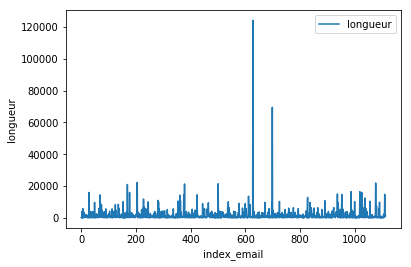

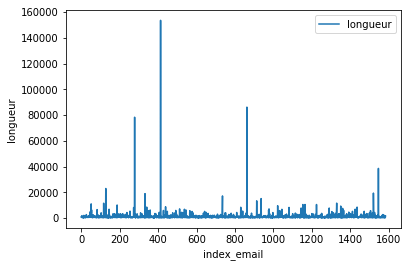

0.5611564121571534
0.4388435878428466
1


In [10]:
import datetime
starttime = datetime.datetime.now()
spam = get_emails_from_file("spam.txt" )
nospam = get_emails_from_file("nospam.txt")
e1,e2 = split(spam,50)
e3,e4 = split(nospam,50)
#longueur(spam[0])
affiche_Hist(spam)
affiche_Hist(nospam)
#data_s,data_ns,modele = apprend_modele(spam,nospam)
#print(data_s)
#print(data_ns)
#print(modele)
####
#Vérifier le modèle#
####
data_appren_s = dataset(e1,+1)
data_appren_ns = dataset(e3,-1)
data_test_s = dataset(e2,+1)
data_test_ns = dataset(e4,-1)
data_test = merge_dataset(data_test_ns,data_test_s)
#print(data_test)
proba_s,proba_ns, modele1 = apprend_modele(data_appren_s['Emails'],data_appren_ns['Emails'])
precision = accuracy(data_test,modele1)
err = erreur(data_test,modele1)
print(precision)
print(err)
endtime = datetime.datetime.now()
print ((endtime - starttime).seconds)
##print(words_set(spam))

In [24]:
starttime = datetime.datetime.now()
modele = train_modele(data_appren_s['Emails'],data_appren_ns['Emails'],1)

In [25]:
modele

[['tion',
  'mail',
  'here',
  'this',
  'your',
  'ation',
  'from',
  'subs',
  'with',
  'ribe',
  'ease',
  'subscr',
  'subscribe',
  'emai',
  'lease'],
 ([-0.1637918322620202,
   -0.203029768214549,
   -0.22734125529584143,
   -0.2407052168538229,
   -0.24206451211654775,
   -0.26441256667142393,
   -0.2819622061878216,
   -0.30652250134346626,
   -0.32097355854266196,
   -0.32260932123692104,
   -0.32589944668397103,
   -0.32921468783544794,
   -0.3531582419140632,
   -0.35492008807034975,
   -0.3584653688349995],
  [-2.8987251815894934,
   -0.21387981994508098,
   -0.29019914801229935,
   -0.3076605745629943,
   -0.5848579612203401,
   -2.8987251815894934,
   -0.39629806160506087,
   -0.6760087104419102,
   -0.2693155824867746,
   -2.8987251815894934,
   -0.7255389131772195,
   -2.8987251815894934,
   -1.0294934618585172,
   -2.8987251815894934,
   -2.8987251815894934])]

In [28]:
predicate(data_test['Emails'],modele)

==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========1

==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

[1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 

In [29]:
precision = accuracy2(data_test,modele)
endtime = datetime.datetime.now()
print ((endtime - starttime).seconds)

==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========1===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1

==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========1===========
==========0

In [30]:
precision

0.6945885841363973

In [34]:
starttime = datetime.datetime.now()
modele2 = train_modele(data_appren_s['Emails'],data_appren_ns['Emails'],1)

In [35]:
modele2 = train_modele(data_appren_s['Emails'],data_appren_ns['Emails'],2)

In [36]:
precision2 = accuracy2(data_test,modele2)
endtime = datetime.datetime.now()
print ((endtime - starttime).seconds)

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

In [37]:
precision2

0.5952557449962935

In [38]:
len(spam)/len(nospam+spam)

0.4128984432913269

In [39]:
starttime = datetime.datetime.now()
modele3 = train_modele(data_appren_s['Emails'],data_appren_ns['Emails'],3)

In [40]:
modele3

[['call',
  'body',
  'late',
  'than',
  'ours',
  'wish',
  'work',
  'service',
  'heir',
  'rest',
  'chan',
  'offe',
  'about',
  'hang',
  'removed',
  'sign',
  'just',
  'cent',
  'year',
  'their'],
 ([-0.7084286972331053,
   -0.7084286972331053,
   -0.7164714174885193,
   -0.7288218558749485,
   -0.7288218558749485,
   -0.7330179704685567,
   -0.7330179704685567,
   -0.7372550234118114,
   -0.7372550234118114,
   -0.7372550234118114,
   -0.7415338213910863,
   -0.7458551951737289,
   -0.7458551951737289,
   -0.750220000576179,
   -0.754629119481234,
   -0.754629119481234,
   -0.754629119481234,
   -0.754629119481234,
   -0.754629119481234,
   -0.754629119481234],
  [-0.6786170935494384,
   -1.2085291015609798,
   -0.8380273412358819,
   -0.7226339225338123,
   -2.8987251815894934,
   -1.6434526764861874,
   -0.4904852162776439,
   -1.2966651902615312,
   -2.8987251815894934,
   -0.8775358825195555,
   -2.8987251815894934,
   -2.8987251815894934,
   -0.5848579612203401,
   -0

In [41]:
precision3 = accuracy2(data_test,modele3)

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0

==========1===========
==========1===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0

==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========1===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0===========
==========1===========
==========0===========
==========0===========
==========0===========
==========0===========
==========0

In [42]:
precision3
endtime = datetime.datetime.now()
print ((endtime - starttime).seconds)

37


In [43]:
precision3

0.69236471460341